In [14]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
 

In [21]:
modeledWorld1 = ModeledPopulatedWorld(500,200)

In [22]:
simulation1 = Simulation(modeledWorld1,200)


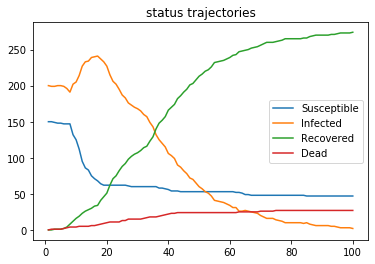

In [23]:
simulation1.plot_status_timecourse()


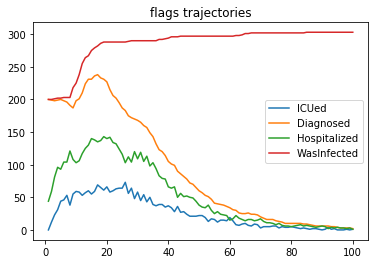

In [24]:
simulation1.plot_flags_timecourse()


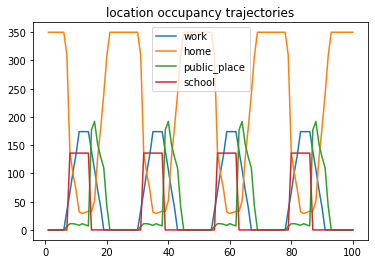

In [25]:
simulation1.plot_location_type_occupancy_timecourse()

In [26]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.
